In [11]:
%pylab inline
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import Row, functions as F
from pyspark.ml.feature import Tokenizer, HashingTF, Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Introduction
In this tutorial, we will use spark.ml to build an ML pipeline using the reddit comment dataset.

We are going to build a model to classify reddit comments as positive or negative based on the content of each comment.



## Read in the Reddit data

In [2]:
fields = [StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("day", LongType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("month", LongType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)]
rawDF = sqlContext.read.json("s3n://reddit-comments/2009", StructType(fields)).persist(StorageLevel.MEMORY_AND_DISK_SER)

## Selecting a subset of the data
To keep the tutorial fast, we'll just use the reddit.com subreddit comments here. You could easily extend this to a general model for comments across all subreddits.

We clean the data by removing deleted comments and comments that do not have a score. We also cast the columns into the correct datatype for Spark's Transformers.


Sample size: 1806276


(0, 50)

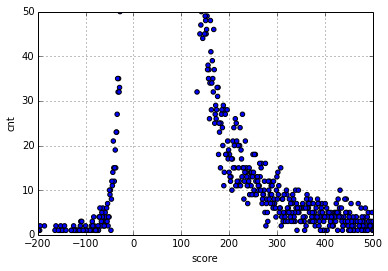

In [3]:
# Select columns that are needed for the training and testing
# Cast columns to the correct datatype for Transformers
# Only use comments that have been upvoted or downvoted
def cast_col(df, col, cast_type):
    '''
    Function to cast column into datatype for Transformers. 
    The format may seem very un-pythonic but because Spark is written in Scala, 
    the columns are immutable and so we need to create a new temporary column (temp_col)
    '''
    return df.withColumn("temp_col", df[col].cast(cast_type))\
             .drop(col)\
             .withColumnRenamed("temp_col", col)

# filter out comments with no score, comments that are deleted, and only use the reddit.com subreddit comments
filteredDF = rawDF.select("id", "body", "score", "score_hidden", "subreddit")\
                  .filter(rawDF.body != "[deleted]")\
                  .filter(rawDF.score_hidden == False)\
                  .filter(rawDF.subreddit == "reddit.com")
castedDF = cast_col(filteredDF, "score", DoubleType())

print "Sample size: {}".format(castedDF.count())

castedDF.registerTempTable("rc")
query = sqlContext.sql("""
    SELECT score, COUNT(*) as cnt FROM rc
    GROUP BY score
    ORDER BY cnt DESC
    """)
result = query.toPandas()


Let's plot the distribution of comment scores to see what the data looks like:

(0, 800000)

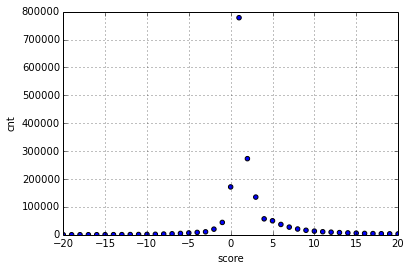

In [30]:
result.plot(x="score", y="cnt", kind="scatter")
plt.xlim([-20,20])
plt.ylim([0, 800000])

Most comments have a score of 1, and the number of comments drops very rapidly on either side of this.

In [14]:
# Take top 5% and bottom 5% of data
extremeDF = sqlContext.sql("SELECT PERCENTILE_APPROX(score, 0.05), PERCENTILE_APPROX(score, 0.95) FROM rc")
extremeDF.take(5)


[Row(_c0=-1.4756260848003966, _c1=12.540093682744645)]

## Creating a labeled dataset
Now that we have cleaned the data, let's create labels for our positive comments and negative comments. 

Since the majority of comments have a score of 0-3, in this example we are going to assume that a comment needs a score < 0 to be a negative comment and > 10 to be a positive comment (10% of the data falls into this classification scheme). 

You probably noticed that conveniently the number of positive comments and the number of negative comments are about equal. A balanced labeled dataset will help simplify training and validating our model.


In [6]:
negativeDF = castedDF.filter(castedDF["score"] < 0)
positiveDF = castedDF.filter(castedDF["score"] > 10)

print negativeDF.count(), positiveDF.count(), castedDF.count()

111414 114957 1806276


## Split into training and testing data
Now let's combine the positive comments and negative comments, and randomly split them into training and testing datasets (80% in the training set, 20% in the testing set). 

We'll put the testing dataset aside for now and use the training dataset to train our model. Once the model is trained, we can use the testing dataset to validate the model.



In [7]:
# Split dataset into training and testing
mergedDF = negativeDF.unionAll(positiveDF)
splitDF = mergedDF.randomSplit([0.8, 0.2])
trainingDF = splitDF[0]
testingDF = splitDF[1]

filtered_trainingDF = trainingDF.filter((trainingDF.score != 0))
print "training size: {}".format(filtered_trainingDF.count())
print "negative sentiment: {}".format(filtered_trainingDF.filter(filtered_trainingDF.score<0).count())
print "positive sentiment: {}".format(filtered_trainingDF.filter(filtered_trainingDF.score>0).count())
print " testing size: {}".format(testingDF.count())


training size: 181099
negative sentiment: 89029
positive sentiment: 92070
 testing size: 45272


## Training a model
As features for our model we are going to use the frequency of each word in a comment.

We build an ML pipeline by chaining together the binarizer, tokenizer, hashingTF and logisticregression. Then we  fit the model to the training dataset and make predictions on the testing dataset.


In [49]:
binarizer = Binarizer(threshold=0.0, inputCol="score", outputCol="label")
tokenizer = Tokenizer(inputCol="body", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

lr = LogisticRegression(maxIter=10, regParam=0.01)

In [56]:
pipeline = Pipeline(stages=[binarizer, tokenizer, hashingTF, lr])
model = pipeline.fit(filtered_trainingDF)
prediction = model.transform(testingDF)

KeyboardInterrupt: 

In [53]:
binarizedDF = binarizer.transform(trainingDF)
tokenizedDF = tokenizer.transform(binarizedDF)
hashingDF = hashingTF.transform(tokenizedDF)
model = lr.fit(hashingDF)


In [54]:
binarizedDFtest = binarizer.transform(testingDF)
tokenizedDFtest = tokenizer.transform(binarizedDFtest)
hashingDFtest = hashingTF.transform(tokenizedDFtest)
prediction = model.transform(hashingDFtest)

## Model validation
Let's look at the accuracy of the model:

In [55]:
selected = prediction.select("id", "body", "prediction", "label")
positive_score_rate = binarizer.transform(mergedDF).map(lambda r: r.label).mean()

def typeI_II(row):
    if row.prediction == 0 and row.label == 0:
        return Row(error_type="true_neg", cnt=1)
    elif row.prediction == 0 and row.label == 1:
        return Row(error_type="false_neg", cnt=1)
    elif row.prediction == 1 and row.label == 0:
        return Row(error_type="false_pos", cnt=1)
    else:
        return Row(error_type="true_pos", cnt=1)

typeI_II_DF = selected.map(lambda r: typeI_II(r)).toDF()
type_error_pd = typeI_II_DF.groupBy("error_type")\
                           .sum("cnt")\
                           .withColumnRenamed("SUM(cnt)", "cnt").toPandas()

type_error_pd["tot"] = type_error_pd["cnt"].sum(axis=0)
type_error_pd["perc"] = type_error_pd["cnt"]/type_error_pd["tot"]
print type_error_pd
print "percentage of comments with positive score in full set: {0:.2f}".format(positive_score_rate)
#print "                                   predictive accuracy: {}".format(accuracy)

  error_type    cnt    tot      perc
0   true_pos  13577  45272  0.299898
1  false_neg   9310  45272  0.205646
2   true_neg  12959  45272  0.286248
3  false_pos   9426  45272  0.208208

[4 rows x 4 columns]
percentage of comments with positive score in full set: 0.51


In [194]:
 rawDF.unpersist()

DataFrame[archived: boolean, author: string, author_flair_css_class: string, body: string, controversiality: bigint, created_utc: string, day: bigint, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, month: bigint, name: string, parent_id: string, retrieved_on: bigint, score: bigint, score_hidden: boolean, subreddit: string, subreddit_id: string, ups: bigint, year: bigint]